# Lab 4.1:  Decision Trees

Decision trees can be used for either regression or classification tasks. Decision trees are a powerful tool; however, are very prone to overfitting the training dataset and therefore often fail to generalize well to test data sets. However, they are the building block for several other powerful machine learning algorithms and are therefore important to learn about.

<img src="./images/DecisionTreeExample.png" alt="Drawing" style="width: 500px;height=500"/>

What we'll be doing in this notebook:
-----

1. Import packages
2. Load data
3. Build a Decision Tree
4. Tune parameters
5. Feature importance
6. Homework
7. Advanced material

Our previous Linear regression model assumes linearity among others.

Whereas decision trees and associated algorithms are no longer restricted to independent variables which have a linear relationship and we don't have to ensure several assumptions are true. 

Therefore we can start to bring in other features that could be useful.

After we run our decision trees, we will compare our new output to our output from the linear regressions we ran in the previous notebook. 

In this notebook, we will be looking at how we can predict the loan amount using decision trees. 

Here is visual introduction to [decision trees](https://algobeans.com/2016/07/27/decision-trees-tutorial/)

## 1. Import packages

In [1]:
import graphviz 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score

If you do not have graphviz installed or are having problems displaying the tree structure later on, try:

Mac/Windows:

```bash
$ brew install graphviz 
```

Linux:

```
$ sudo apt-get install graphviz
```

## 2. Load and format data

In [2]:
# Load data
path = '../data/'
filename = 'loans.csv'
df = pd.read_csv(path+filename)

We are going to build regressors to predict the loan amount and we will build a tree that considers many the features in the dataset - including those we have engineered ourselves.

Here we choose a limited subset of data to conduct the analysis for the sake of training time. In practice, we should use more features. This is a mix of numeric and one hot-coded categorical variables. 

We are going to build regressors to predict the loan amount and we will build a tree that considers many the features in the dataset - including those we have engineered ourselves.

In [16]:
# Drop everything that not numeric
df = df.select_dtypes(exclude=['object'])

In [20]:
y_column = 'loan_amount'
y = df[y_column]
# Drop returns a copy of the DataFrame with the specified columns removed.  
X = df.drop([y_column, "id_number"], axis=1) # id_number will not be helpful

In [22]:
# Split data into training and testing sets;
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Build a Decision Tree
We will use sklearn's implementation of a Decision Tree Regressor and to learn how to use it, here are the [docs](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.get_params), or simply put a question mark before a call to the class.  

Prepending a ? to any method, variable, or class will display that method's defined docstring (way to go IPython!)

In [23]:
DecisionTreeRegressor?

Many of the sklearn algorithms are implemented using the same standard steps: 
- **Step 1: Initiate the algorithm** Define the parameters (& hyperparameters of the algorithm) of the algorithm. For example, the maximum depth, the minimum samples in a leaf etc. (check documentation for more information)

- **Step 2: Train the algorithm** Train the algorithm by fitting it to the X_train and y_train datasets.

- **Step 3: Evaluating the algorithm** Evaluate the predictive power of the algorithm by comparing the predictive loan amount values to the true values. We can do this for the training and testing dataset.

Here is a function which encapsulates the 3 model implementation steps; Initialize, Train, Evaluate our decision tree regressor. 

In [24]:
def train_score_regressor(sklearn_regressor, X_train, y_train, X_test, y_test, model_parameters):
    """A help function that:
        - train a regressor on training data
        - score data on training and test data
        - return trained model
    """
    # Step 1: Initializing the sklearn regressor 
    regressor = sklearn_regressor(**model_parameters)
    
    # Step 2: Training the algorithm using the X_train dataset of features and y_train, the associated target features
    regressor.fit(X_train, y_train)
    
    # Step 3: Calculating the score of the predictive power on the training and testing dataset.
    training_score = regressor.score(X_train, y_train)
    testing_score = regressor.score(X_test, y_test)
    
    # Print the results!
    print(f"Train score: {training_score:.4}")
    print(f"Test score: {testing_score:.4}")
        
    return regressor

With all tree algorithms the major challenge is using the parameters to balance the bias vs variance trade-off.  

To start, check how the model preforms when using the default values.

In [26]:
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X_train, 
                                          y_train=y_train, 
                                          X_test=X_test, 
                                          y_test=y_test, 
                                          model_parameters={'random_state':42})

Train score: 0.9926
Test score: 0.9035


Our module managed to get a perfect r2 scored on the training data but performs poorly on the test data.  This is a clear indication that the model has **overfit to the training data**.

The default sklearn's implementation of a DecisionTreeRegressor does not put any restrictions on the depth of the tree, the number of samples per leaf, etc.  Consequently, the model finds signal in the noise of the training data set, overfits and performs poorly on the test data.  

When a model overfits to a training data set, we say it has **high variance**.  Since an unconstrained decision tree will almost perfectly model any training data, it will vary tremendously depending on the training data that is provided.

### 4. Parameter tuning
To reduce the variance, we constrain the model using some of the provided parameters for example:
- Criterion (Cost function used to measure the purity of a split)
- Maximum depth of the tree
- Minimum samples for each node split
- Minimum samples for each terminal node
- Maximum number of terminal nodes

Look back over the [slides](https://docs.google.com/presentation/d/1leWPbwis9GJHJcQehlhPhtKEAErUPvlTpKjnkv1aWWU/edit?usp=sharing) or use this [useful blog](https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/#four) for a refresher on decision tree parameters.

Initially, we are going to experiment with the max_depth parameter only. 

In [27]:
# Define the model parameters 
# We are fixing the random state so that the results are reproducible and consistent.
parameters = {"max_depth":6,
              'random_state':42}

# Train and evaluate the model
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X_train, 
                                          y_train=y_train, 
                                          X_test=X_test, 
                                          y_test=y_test, 
                                          model_parameters=parameters)

Train score: 0.9786
Test score: 0.9042


Although the training r2 score has dropped significantly, the test r2 score increased. Since the goal is develop a model that accurately predict data we have never seen, that is the metric we care about!

Now that we have increased preformance, let's take a look at what the Decision Tree looks like.

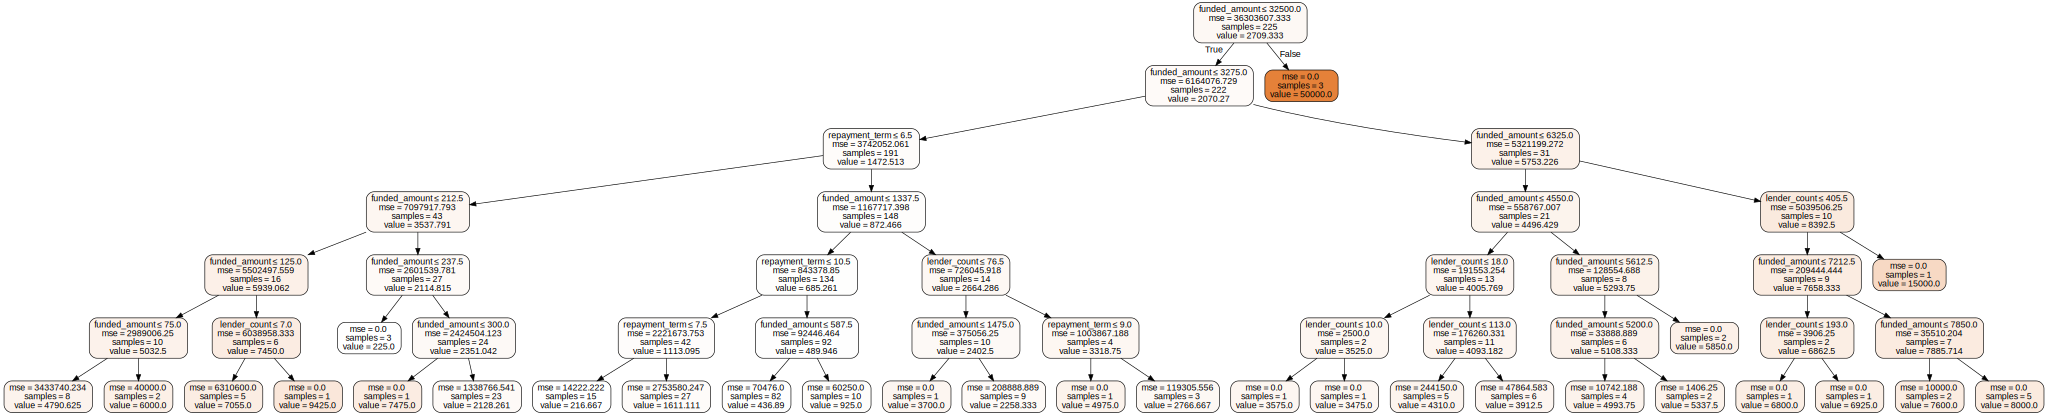

In [29]:
# from the sklearn tree library, create image of trained decision tree
dot_data = tree.export_graphviz(trained_regressor, out_file=None, 
                         feature_names=X_train.columns,  
                         class_names=y_train.values,  
                         filled=True, rounded=True,  
                         special_characters=True) 
# use graphviz to render the image
graph = graphviz.Source(dot_data) 
graph

** IMPORTANT**

A DecisionTreeRegressor with a max depth of only 4 is still rather complicated. To develop your intuition for the various input parameters, manually adjust them up and down to see the impacts.

Overall we're aiming for the highest predictive power on the test set. However, if you were to tune the parameters manually towards a higher score on the test data set, we would overfit to this specific test data set and the model would not generalize well to a secondary test data set.  
To avoid this, we will use k-fold validation. In addition to k-fold validation, we will use sklearn's GridSearchCV, which allows us using k-fold validation to assess every permuation of possible values for the parameters that we provide. See the [Advanced Material](#AdvancedCV) at the bottom of this notebook for a quick overview of these two methods.

**Note** since we are training one regressor one time for each possible permutation of specified parameter values, this next cell will take some time to run.  That is why you need to gain an intuition for which values to test!

In [30]:
# Set parameters to search through - known as parameter grid
parameters = {'max_depth':[8,10,14], 
              'min_impurity_decrease': [.1,.01, 0.0],
              'min_samples_split': [10, 50, 2]}
# Initialize model
decision_regressor= DecisionTreeRegressor(random_state=42)

# Initialize GridSearch and then fit
regressor = GridSearchCV(decision_regressor, parameters)
regressor.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [8, 10, 14], 'min_impurity_decrease': [0.1, 0.01, 0.0], 'min_samples_split': [10, 50, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
# print out what GridSearchCV found to be the best parameters 
regressor.best_estimator_.get_params()

{'criterion': 'mse',
 'max_depth': 14,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.1,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 42,
 'splitter': 'best'}

In [32]:
# evaluate the tuned model
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X_train, 
                                          y_train=y_train, 
                                          X_test=X_test, 
                                          y_test=y_test, 
                                          model_parameters=regressor.best_estimator_.get_params())

Train score: 0.9831
Test score: 0.9042


Performance on the test data has increased again - not bad!

The R^2 number above is pretty telling but it is always good to visualise how these look in a scattor plot.

In [33]:
# plotting a graph of the true values vs the predicted values for the training and test datasets
def plot_y_yhat_scatter(y_actual,y_predicted,train_test):
    ax = sns.regplot(x=y_actual, y=y_predicted, fit_reg=False)
    ax.set_xlabel('true values')
    ax.set_ylabel('predicted values')
    ax.set_title('Relationship between true and predicted loan amounts: '+train_test+' results')
    pass

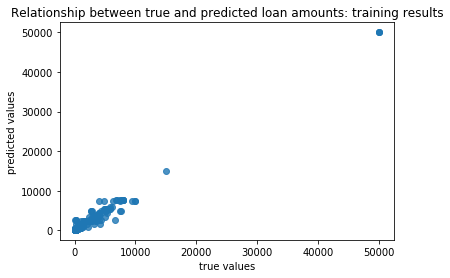

In [34]:
plot_y_yhat_scatter(y_train, trained_regressor.predict(X_train),train_test = "training")

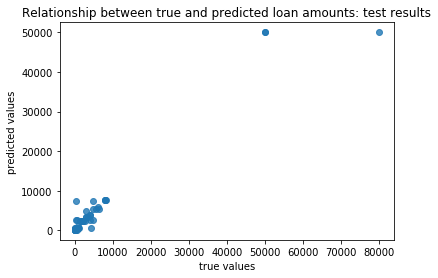

In [35]:
plot_y_yhat_scatter(y_test, trained_regressor.predict(X_test),train_test = "test")

## 5. Feature Importance

We can look at which features are driving our model's predictions by examining the feature importance. 

Remember the magnitude of the 'importance' is not indicative of how important the feature is, only the order matters!

For example,
- feature A has an importance of 0.5 
- feature B has an importance of 0.25. 

All we can take away is that feature A explains more variance then feature B, **not** that feature A explains twice as much as feature B. 

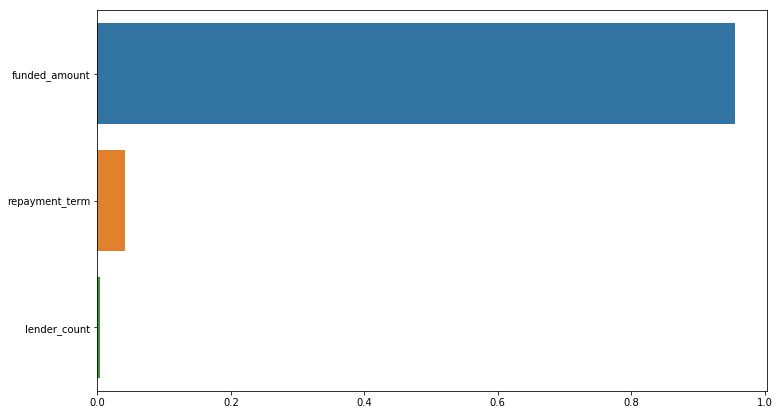

In [37]:
# Get the feature importances from our final trained model...
importances = trained_regressor.feature_importances_

# Find the indices of the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plotting a bar chart of feature importances in descending order
plt.figure(figsize=(12,7))
sns.barplot(y=X_train.columns[indices],x=importances[indices]);

There is not a clear relationship between any single feature and the loan_amount. The most important feature borrower count for One Acre Fund during their high loan period - this is very specific to just a small subset of the data. 

However the aggregate of these features together into the decision leads to effective predictions (R^2 ~ 0.66). This is a testament to the predictive power of decisions trees!

Remember that Decision Trees can also be used to classify data.
For example some interesting classification questions we could investigate are:

- Can we classify which loans expired and which one got funded?
- Is a loan posted by a male or female?

## 6. Advanced Material: Optimising the algorithm
<a id='AdvancedCV'></a>

### K-folds example for finding optimal parameters 

K-folds is a method of evaluating and tuning a model on the given dataset without overfitting to either the training dataset or the testing dataset. It finds the optimal balance between bias and variance in the model. 

Below we show how the model performs on the training and test datasets while varying the max tree depth. 

Text(0.5,0,'Max depth of the tree')

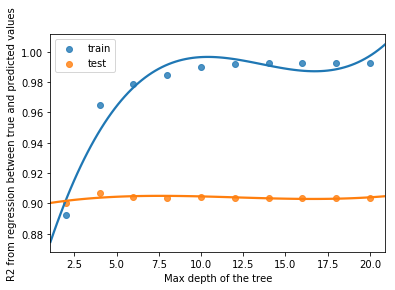

In [38]:
# define max depth range
depth_range = np.asarray(range(2,22,2))

# initialize empty arrays to store the results
scores_train = np.zeros(len(depth_range))
scores_test = np.zeros(len(depth_range))

for i in range(len(depth_range)):
    # train DTR with given max depth
    dt_regressor = DecisionTreeRegressor(max_depth=depth_range[i], random_state=42)
    model = dt_regressor.fit(X_train, y_train)
    # evaluate on both training and test datasets
    scores_train[i] = model.score(X_train, y_train)
    scores_test[i] = model.score(X_test, y_test)

# plot the results on the same graph
ax = sns.regplot(x=depth_range, y=scores_train, order=3, ci=None,label='train')
sns.regplot(x=depth_range, y=scores_test,order=3, ci=None, label='test', ax=ax)
ax.legend(loc='best')
ax.set_ylabel('R2 from regression between true and predicted values')
ax.set_xlabel('Max depth of the tree')


As the depth increases:
- The training score increases
- But the testing score decreases

Once the test score starts decreasing, this indicates that the model is overfitting. 

We could be tempted to say that the optimal depth is 8 as this corresponds to the maximum score for the testing data. **This is not always the case**. The test set is just random fixed subset of data so choosing the optimal parameter here would be overfitting to the testset. 

This is where K-Folds cross validation comes in! This method does the following:
- Splits the dataset K equal random subsests
- Trains the data on K-1 subsets
- Evaluates performance on Kth left out subset
- Stores evaluation metric
- Repeats for K times for each random subset

If K = 5, the algorithm trains 5 times. Each time it holds out a 5th of the data, trains on the other 4/5ths and then evaluates the performance on the held out 5th. 

Here is an example of how the cross validation score changes with maximum tree depth

In [39]:
# initialize empty array to store results
scores_cv = np.empty(len(depth_range))
for i in range(len(depth_range)):
    # initialize model
    dt_regressor = DecisionTreeRegressor(max_depth=depth_range[i], random_state=42)
    # calculate the cross val scores. This returns an array where each element corresponds to the performance on each k-fold.
    cv_scores = cross_val_score(dt_regressor, X_train, y_train,cv=5, n_jobs=-1)
    # calculate mean cross validation score and save
    scores_cv[i] = np.mean(cv_scores)

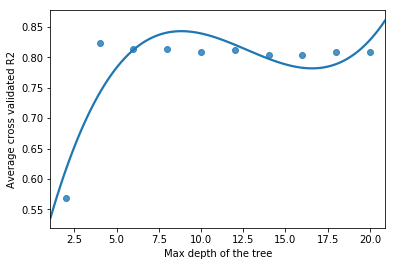

In [41]:
# plot results
ax = sns.regplot(x=depth_range, y=scores_cv, ci=None, order=3);
ax.set_xlabel('Max depth of the tree');
ax.set_ylabel('Average cross validated R2');

Again we see the same general trend of the score increasing intially and then dropping off. From this curve, the optimal max_depth would be between 8 and 10.

### GridSearchCV (CV = cross validation)
Above we were looking at a single parameter. However, to increase performance we should adjust several parameters. 

Sklearn's GridSearchCV uses the cross-validation above to assess the performance of **each possible permutation** of the hyper-parameters that you specify. For this reason, care should be taken to choose the correct range of parameters to search through as adding an additional parameter can increase the search time exponentially.

It then returns a model initialised with the optimal parameters.

In [ ]:
GridSearchCV?

In [42]:
parameters = {'min_impurity_decrease': [.1, 0.01, 0.],
              'max_depth': [None, 5, 8, 10]}

# initialize model
gridrf = DecisionTreeRegressor()

# set up and fit gridsearchCV
grid_rf = GridSearchCV(gridrf, parameters)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_impurity_decrease': [0.1, 0.01, 0.0], 'max_depth': [None, 5, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
# evaluate the tuned model
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X_train, 
                                          y_train=y_train, 
                                          X_test=X_test, 
                                          y_test=y_test,  
                                          model_parameters=grid_rf.best_estimator_.get_params())

Train score: 0.9711
Test score: 0.9076


We can check the variation in the mean cross validation score for the different parameter permutations in the grid search and see which parameters have the biggest impact on performance. 

In this particulatr case, it shows the max_depth has the biggest impact.

In [44]:
# get the cross validation mean score and associated std across the K folds
means = grid_rf.cv_results_['mean_test_score']
stds = grid_rf.cv_results_['std_test_score']
# print the mean, std and parameters for each permutation
for mean, std, params in zip(means, stds, grid_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

0.811 (+/-0.277) for {'max_depth': None, 'min_impurity_decrease': 0.1}
0.812 (+/-0.271) for {'max_depth': None, 'min_impurity_decrease': 0.01}
0.808 (+/-0.286) for {'max_depth': None, 'min_impurity_decrease': 0.0}
0.845 (+/-0.237) for {'max_depth': 5, 'min_impurity_decrease': 0.1}
0.857 (+/-0.204) for {'max_depth': 5, 'min_impurity_decrease': 0.01}
0.856 (+/-0.205) for {'max_depth': 5, 'min_impurity_decrease': 0.0}
0.818 (+/-0.260) for {'max_depth': 8, 'min_impurity_decrease': 0.1}
0.820 (+/-0.253) for {'max_depth': 8, 'min_impurity_decrease': 0.01}
0.824 (+/-0.245) for {'max_depth': 8, 'min_impurity_decrease': 0.0}
0.824 (+/-0.240) for {'max_depth': 10, 'min_impurity_decrease': 0.1}
0.825 (+/-0.239) for {'max_depth': 10, 'min_impurity_decrease': 0.01}
0.821 (+/-0.250) for {'max_depth': 10, 'min_impurity_decrease': 0.0}


In your own words, summarize what you found about the loan behavior.

What are the most import factors? What advice would you give someone to maximize their chance of being successful with a KIVA loan?
<br>
<br> 
<br>

----